In [ ]:
# Install SimpleITK
!pip install SimpleITK

In [ ]:
# # Mount drive to colab
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/White_Matter'
os.chdir(root_dir)
os.listdir()

In [ ]:
# Import libraries
import os
import numpy as np
import sys

import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

## Loading Images to Segment


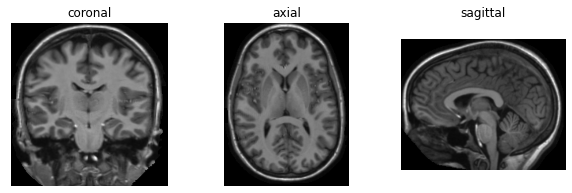

In [ ]:
# load function from file display.py
from display import Display3D

# load image as float32
sitk_image = sitk.ReadImage('image/image.nii.gz', sitk.sitkFloat32)
# display the loaded image
Display3D(sitk_image)

##Masking

Remove the non-brain tissues.
* register the atlas to the image using affine registration
* propagate the mask that comes with the atlas to the image
* multiply the image by the mask to remove the non-brain tissue



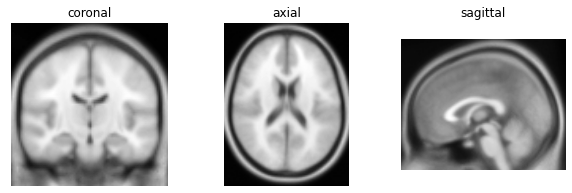

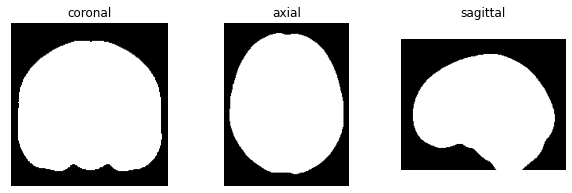

In [ ]:
sitk_atlas = sitk.ReadImage('atlas/t1.nii.gz', sitk.sitkFloat32)
sitk_mask = sitk.ReadImage('atlas/mask.nii.gz', sitk.sitkFloat32)
Display3D(sitk_atlas)
Display3D(sitk_mask)

Register the atlas to the image

* register atlas to the image using affine transformation
* resample altas on the grid of the image using this transformation

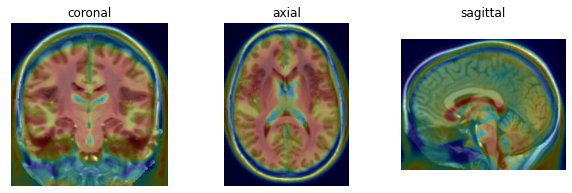

In [ ]:
# import function from display.py
from display import PlotOverlay3D
# images are misaligned
PlotOverlay3D(sitk_image,sitk_atlas,0.3,'jet')

In [ ]:
# import functions from registration.py
from registration import AffineRegistration
from registration import resample_image

In [ ]:
# run affine registration of atlas to image
transf = AffineRegistration(sitk_image,sitk_atlas)

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
-------
itk::simple::Transform
 AffineTransform (00000193CF0C26E0)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 3
   Modified Time: 2105
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.10893 -0.0294653 -0.00437489 
     0.0221134 0.999565 -0.0853273 
     0.0161121 0.0804427 1.15179 
   Offset: [-7.11811, -11.8462, -11.6258]
   Center: [109, 140.5, -119.5]
   Translation: [1.13789, 0.699761, -16.7062]
   Inverse: 
     0.901173 0.0261336 0.00535901 
     -0.0208883 0.9939 0.0735511 
     -0.0111474 -0.0697811 0.863002 
   Singular: 0

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (20) exceeded.
 Iteration: 20
 Metri

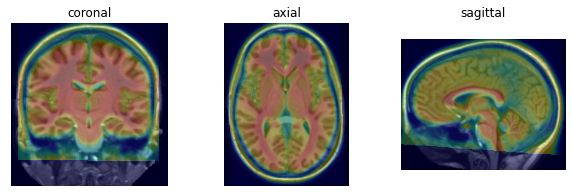

In [ ]:
# resample atlas to image space
sitk_atlas_reg = resample_image(sitk_image, sitk_atlas, transformation = transf)

# display overlay to check that images are aligned
PlotOverlay3D(sitk_image,sitk_atlas_reg,0.3,c='jet')

Propagate mask to the image
* resample mask on the grid of the image using the affine transformation
* display resampled mask overlayed on the image

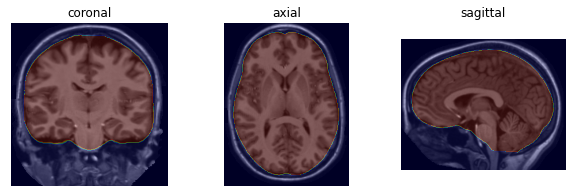

In [ ]:
# resample
sitk_mask_reg = resample_image(sitk_image, sitk_mask, transformation = transf)
# display
PlotOverlay3D(sitk_image,sitk_mask_reg,0.3,'jet')

Remove non-brain tissue from the image
* extract the the aligned mask and the image as numpy arrays from the sitk images
* binarize the mask by thresholding at 0.5
* multiply mask and image
* convert back to sitk image

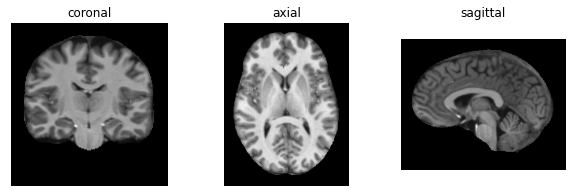

In [ ]:
# extract numpy arrays
image = sitk.GetArrayFromImage(sitk_image)
mask = sitk.GetArrayFromImage(sitk_mask_reg)

# binarise mask at 0.5
mask[mask>=0.5]=1
mask[mask<0.5]=0

# multiply image with the mask
image_masked = image*mask

# convert masked image to sitk
sitk_image_masked = sitk.GetImageFromArray(image_masked)
sitk_image_masked.CopyInformation(sitk_image)

# display masked image
Display3D(sitk_image_masked)

## Segmentation using Gaussian Mixture Model


 3-class Gaussian Mixture Model from __scikit-learn__ to segment the masked image.

 3-class segmentation of the maked image using `sklearn GaussianMixture`.
* convert sitk image to numpy (or use the one already created)
* extract non-zero voxels
* perform GMM clustering and predict labels
* reshape labels back to 3D array and convert to sitk image
* display the resulting segmentation

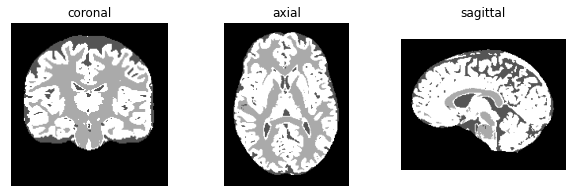

In [ ]:
from sklearn.mixture import GaussianMixture

# extact non-zero values and reshape into feature vector for sklearn
ind = np.where(image_masked>0)
data = image_masked[ind]
features = data.reshape(-1,1)

# create GMM model, fit and predict labels
model_gmm=GaussianMixture(n_components=3)
model_gmm.fit(features)
labels=model_gmm.predict(features)

# reshape labels to a 3D image
labels3D = np.zeros_like(image_masked)
labels3D[ind] = labels+1;

# convert to sitk image
sitk_labels = sitk.GetImageFromArray(labels3D)
sitk_labels.CopyInformation(sitk_image)

# display segmentation
Display3D(sitk_labels)

Evaluate segmentation
* Extract binary white matter label from the segmentation and display it
* calculate Dice Coefficient between GMM and manual segmentation of WM
* calculate Hausdorff distance and average Hausdorf distance

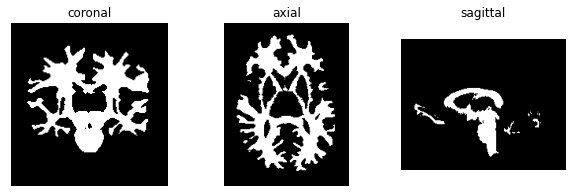

In [ ]:
# load ground truth segmentation
sitk_gt = sitk.ReadImage('ground_truth/wm.nii.gz', sitk.sitkFloat32)
Display3D(sitk_gt)

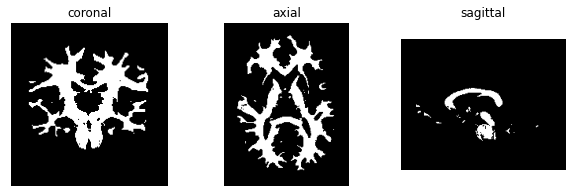

In [ ]:
# extract WM label from numpy label array
def extract_wm(labels,c):
    wm = np.zeros_like(labels)
    wm[labels==c]=1
    return wm
wm_gmm = extract_wm(labels3D,2)

# convert to sitk
sitk_wm_gmm = sitk.GetImageFromArray(wm_gmm)
sitk_wm_gmm.CopyInformation(sitk_image)

# display wm label
Display3D(sitk_wm_gmm)

In [ ]:
# Import Dice function from segmentation.py
from segmentation import Dice

# Calculate Dice Coefficient (use numpy arrays)
gt = sitk.GetArrayFromImage(sitk_gt)
Dice(wm_gmm,gt)

Dice = 0.84


In [ ]:
# import Housdorf function from segmentation.py
from segmentation import Hausdorff

# calculate Hausforff and average Housdorff distances. Use sitk images to do that.
Hausdorff(sitk_wm_gmm,sitk_gt)

Housford distance: 15.17
Average Housedorf distance: 0.21


Evaulating the performance of the segementation using the three quantitative measures


Dice coefficient is high, which shows good quality segmentation. However, depending on the random initialisation, Dice is either 0.93 or 0.84, showing the instability of GMM.

Average Hausforff distance is only 0.12mm (or 0.21mm
), which shows high accuracy on average. However, maximum surface distance is 13mm (or 15mm), so there are some misclassified voxels very far from surface of WM.

By visual inspection we can observe oversegmentation (or different shape, depending on the run) of the WM in the centre of the brain which is probably a major cause of the error. It is questionable whether manual segmentation is actually correct in this area.

Gaussian Mixture Model

* Initialise GMM parameters, which include cluster means, variances and mixing proportions
* Implement 10 iterations of EM algorithm, where in E-step you update probability maps and in M-step you update the parameters
* Create a segmentation from the probability maps and display it

In [ ]:
# import functions from segmentation.py
from segmentation import init_parameters
from segmentation import update_probability
from segmentation import update_parameters
from segmentation import create_segmentation

In [ ]:
# initialise GMM parameters
means, variances, mix = init_parameters(features)

means [27.43 54.86 82.29]
variances [270.84 270.84 270.84]
mix [0.33 0.33 0.33]


In [ ]:
# implement 10 iteration of to update probability maps and parameters
for i in range(10):
    p = update_probability(features,means,variances,mix)
    means, variances, mix = update_parameters(features,p)

means [33.04 54.23 75.36]
variances [129.45 130.13  51.97]
mix [0.27 0.44 0.3 ]
means [32.3  52.96 76.23]
variances [115.13  78.65  24.45]
mix [0.27 0.41 0.32]
means [32.01 53.04 76.51]
variances [109.52  66.84  20.7 ]
mix [0.27 0.41 0.32]
means [32.06 53.3  76.59]
variances [107.61  65.54  19.89]
mix [0.28 0.41 0.32]
means [32.22 53.51 76.66]
variances [107.72  65.53  19.4 ]
mix [0.28 0.4  0.32]
means [32.4  53.7  76.71]
variances [108.35  65.65  19.02]
mix [0.29 0.4  0.31]
means [32.59 53.88 76.75]
variances [109.07  65.7   18.69]
mix [0.29 0.4  0.31]
means [32.78 54.05 76.79]
variances [109.82  65.66  18.41]
mix [0.29 0.39 0.31]
means [32.97 54.23 76.83]
variances [110.56  65.53  18.16]
mix [0.3  0.39 0.31]
means [33.17 54.4  76.86]
variances [111.3   65.33  17.95]
mix [0.3  0.39 0.31]


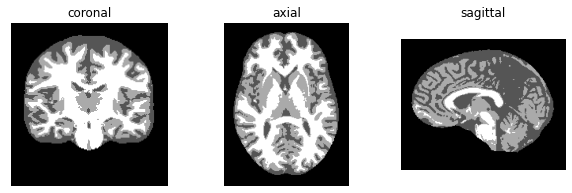

In [ ]:
# create and display segmentation
sitk_seg = create_segmentation(sitk_image,ind,p)
Display3D(sitk_seg)

## EM segmentation with probabilistic atlas

* resample the the atlas probability maps for WM, GM and CSF to the space of an image using the affine transformation
* update functions for E-step and M-step  to repace mixing proportions by the probability maps
* run the algotihm for 10 iterations and create the segmentation
* evaluate the accuracy of the WM segmentation using Dice, Hausforff and average Hausdorff distance


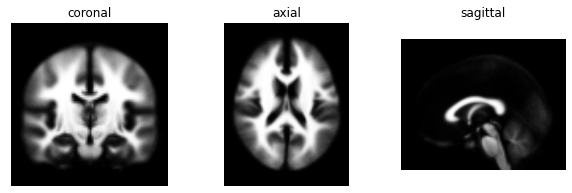

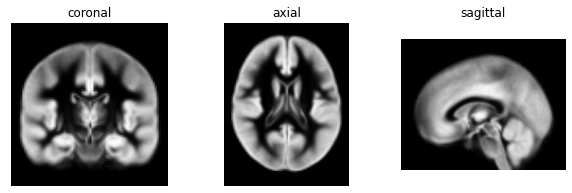

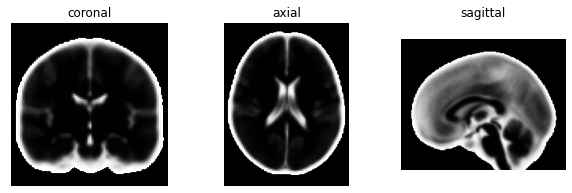

In [ ]:
# load the probability maps
sitk_wm = sitk.ReadImage('atlas/wm.nii.gz', sitk.sitkFloat32)
sitk_gm = sitk.ReadImage('atlas/gm.nii.gz', sitk.sitkFloat32)
sitk_csf = sitk.ReadImage('atlas/csf.nii.gz', sitk.sitkFloat32)

# display
Display3D(sitk_wm)
Display3D(sitk_gm)
Display3D(sitk_csf)

Align the probability maps loaded above to the space of the image.
* Resample them to the space of the image using affine transformation
* Display each of the three probability maps overlayed on the image to check the alignment
* Convert each probability map into numpy array to prepare it for EM segmentation.

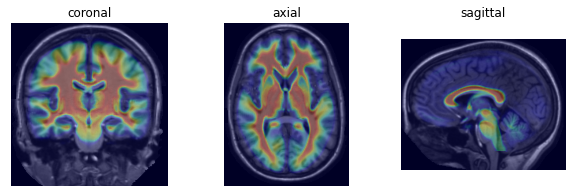

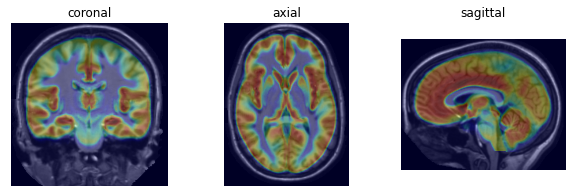

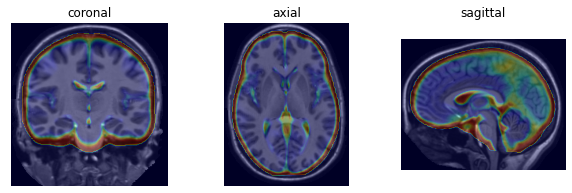

In [ ]:
# Resample probability maps for WM, GM ans CSF
sitk_wm_reg = resample_image(sitk_image, sitk_wm, transformation = transf)
sitk_gm_reg = resample_image(sitk_image, sitk_gm, transformation = transf)
sitk_csf_reg = resample_image(sitk_image, sitk_csf, transformation = transf)

# Display probability maps as overlay on the image to check that they are aligned
PlotOverlay3D(sitk_image,sitk_wm_reg,0.3,c='jet')
PlotOverlay3D(sitk_image,sitk_gm_reg,0.3,c='jet')
PlotOverlay3D(sitk_image,sitk_csf_reg,0.3,c='jet')

# Convert to numpy
wm_reg = sitk.GetArrayFromImage(sitk_wm_reg)
gm_reg = sitk.GetArrayFromImage(sitk_gm_reg)
csf_reg = sitk.GetArrayFromImage(sitk_csf_reg)

Initialise the EM segmentation

* create an initial probability vector `a` using probabilistic atlas
* initialise means and variances by updated M-step function `update_parameters_EM`

The cell below contains code to extract probability map voxels corresponding to non-zero intensities in the masked image and join the probability maps into a single probability vector.

In [ ]:
# extract prior probabilities for non-zero voxels
a_wm = wm_reg[ind]
a_gm = gm_reg[ind]
a_csf = csf_reg[ind]

# stack them into a single vector
a=np.stack([a_csf,a_gm,a_wm],axis=1)
a.shape

(1626229, 3)

First and second dimension of the vector `a` represents:


* first dimension: number of features (non-zero voxels in the image)
* second dimension: number of clusters (tissue probability maps): WM, GM, CSF

Initialising the EM segmentation parameters (means and variances) by running the M-step.
* Function `update_parameters_EM` so that it does not calculate or return the mixing proportions, as these will be replaced by the probabilistic atlas
* Function using the probability map vector `a` constructed in the cell above to calculate and print initial means and variances.

In [ ]:
def update_parameters_EM(features,p):
    n=p.shape[0]
    means=np.zeros(3)
    variances=np.zeros(3)
    #mix=np.zeros(3)
    for k in range(0,3):
        means[k]=np.sum(p[:,k]*features.flatten())/np.sum(p[:,k])
        variances[k]=np.sum(p[:,k]*(features.flatten()-means[k])**2)/np.sum(p[:,k])
        #mix[k] = np.sum(p[:,k])/n
    print('means', np.around(means,2))
    print('variances', np.around(variances,2))
    #print('mix',np.around(mix,2))
    return means,variances#,mix

# run function
means, variances = update_parameters_EM(features,a)

means [40.71 53.84 64.93]
variances [344.36 272.05 252.44]


Updating the E-step function `update_probability_EM`.
* remove the `mix` parameters, as they will not be used any more
* when calculating likelihoods `p`, replace `mix[k]` with with the prior probability maps `a`
* function to calculate posterior probability maps `p`

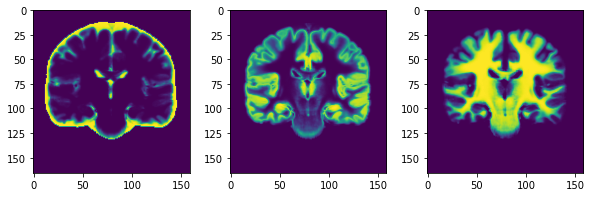

In [ ]:
from segmentation import gauss

# amend function
def update_probability_EM(features,means,variances): #,mix):
    p=np.zeros([features.shape[0],3])
    for k in range(3):
        p[:,k] = gauss(features.flatten(),means[k],variances[k])*a[:,k]  #mix[k]
    denom = np.matlib.repmat(np.sum(p,1), 3, 1).T
    p=p/denom
    return p

# run function
p = update_probability_EM(features,means,variances)

# print probability maps
from segmentation import plot_probability
plot_probability(sitk_image, ind, p)

Calculate EM segmentation.
* Run the new E-step and M_step for 10 iterations
* Create the segmentation
* Display the resulting segmentation

In [ ]:
# Run the new E-step and M_step for 10 iterations
for i in range(10):
    p = update_probability_EM(features,means,variances)
    means, variances = update_parameters_EM(features,p)

means [34.73 52.13 71.21]
variances [219.66 173.21 119.08]
means [32.33 50.24 74.53]
variances [176.45  97.05  44.67]
means [31.11 50.13 75.54]
variances [164.44  69.75  25.14]
means [30.81 50.75 75.94]
variances [157.01  67.32  20.37]
means [30.82 51.27 76.23]
variances [152.63  69.37  17.87]
means [30.89 51.65 76.47]
variances [150.97  72.16  16.06]
means [30.96 51.95 76.66]
variances [150.57  74.9   14.67]
means [31.03 52.19 76.81]
variances [150.63  77.37  13.61]
means [31.09 52.38 76.93]
variances [150.81  79.49  12.8 ]
means [31.14 52.53 77.03]
variances [150.98  81.28  12.18]


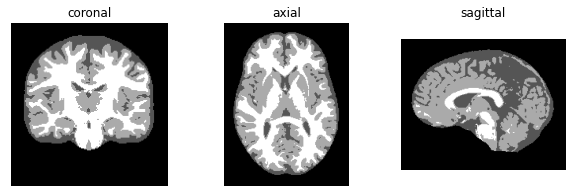

In [ ]:
# Create and display segmentation (see Q3)
sitk_seg_EM = create_segmentation(sitk_image,ind,p)
Display3D(sitk_seg_EM)

Calculate Dice coefficient, Hausdorf distance and average Housdorff distance  for the EM segmentation compared to the ground truth WM segmentation.

Dice = 0.85
Housford distance: 15.13
Average Housedorf distance: 0.19


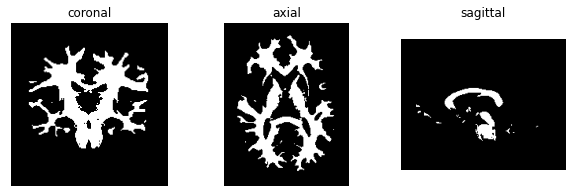

In [ ]:
# extract EM segmentation as numpy array
seg_EM = sitk.GetArrayFromImage(sitk_seg_EM)

# extract WM label
wm_EM = extract_wm(seg_EM,3)

# calculate Dice
Dice(wm_EM,gt)


# convert to sitk
sitk_wm_EM = sitk.GetImageFromArray(wm_EM)
sitk_wm_EM.CopyInformation(sitk_image)

# display wm label
Display3D(sitk_wm_EM)

# Calculate Housdorff distances
Hausdorff(sitk_wm_EM, sitk_gt)

## Label propagation


Load the template and template WM labels to ants format and plot the labels overlayed on the template using ants library plotting function:

In [ ]:
# install ants
# works on Colab but might not work on your local system
!pip install antspyx

In [ ]:
# import ants
import ants

In [ ]:
# load the template and the WM labels in ants format
ants_template = ants.image_read('template/template.nii.gz')
ants_template_wm = ants.image_read('template/wm.nii.gz')
ants.plot(ants_template, ants_template_wm,
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3,
          title="Template with WM labels")

Load the image in ants format and overlay the template on it.

In [ ]:
# load the image in ants format
ants_image = ants.image_read('image/image.nii.gz')

# image and template are not aligned
ants.plot(ants_image, ants_template,
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3,
          title="Image and template not aligned")

Perform affine registration of template to image and transform the template to the image and show aligment using overay from ants package.

In [ ]:
# perform affine registration (takes ~40s)
t_affine = ants.registration( fixed=ants_image, moving=ants_template,
                               type_of_transform='Affine' )
# transform template
ants_template_affine = ants.apply_transforms( fixed=ants_image, moving=ants_template, interpolator='linear',
                                           transformlist=t_affine['fwdtransforms'] )
# check alignment
ants.plot(ants_image, ants_template_affine,
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3,
          title="Affine alignment")

Perform non-linear alignment, initialised by affine transformation.

In [ ]:
# perform non-linear registration initialised with affine
t_nonlinear = ants.registration( fixed=ants_image, moving=ants_template,
                            initial_transform = t_affine['fwdtransforms'][0],
                            #reg_iterations = [40,20,0], # lower quality
                            reg_iterations = [40,40,40], # higher quality
                            type_of_transform='SyNOnly')

ants_template_nonlinear = ants.apply_transforms( fixed=ants_image, moving=ants_template, interpolator='linear',
                                         transformlist=t_nonlinear['fwdtransforms'] )
ants.plot(ants_image, ants_template_nonlinear,
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.3,
          title="Nonlinear alignment")

Propagate the template WM labels from template to image space. Plot propagated labels overlayed on the image using the ants package.

In [ ]:
# propagate labels
propagated_labels = ants.apply_transforms( fixed=ants_image, moving=ants_template_wm, #domain_image=fixed_image,
                                             interpolator='nearestNeighbor', transformlist=t_nonlinear['fwdtransforms'] )
# plot propagated labels overlayed on the image
ants.plot(ants_image, propagated_labels,
          axis=2, ncol=7, nslices=7, overlay_cmap="jet", overlay_alpha=0.5,
          title="Propagated labels")

 Calculate the Dice coefficient and Hausforff distances, after converting the ants propagated and ground truth WM labels into appropriate formats.

In [ ]:
# Dice

# read ground truth segmentation in ants format
ants_gt = ants.image_read('ground_truth/wm.nii.gz')

# calculate dice coefficient
Dice(propagated_labels.numpy(),ants_gt.numpy())

In [ ]:
# Hausdorff

# convert ants images first to numpy and then to sitk
sitk_propagated_labels = sitk.GetImageFromArray(propagated_labels.numpy())
sitk_gt_from_ants = sitk.GetImageFromArray(ants_gt.numpy())

# calculate Hausforf distances
Hausdorff(sitk_propagated_labels,sitk_gt_from_ants)

Analyse the performance of the three WM segmentation methods (GMM, EM with probabilistic atlas, label propagation) in terms of their quantitative results.



Measure                   | GMM (1) | GMM (2) | EM    | Label Propagation |
----------------          |-------  |-------- |------ | ----------------
Dice                      | 0.93    | 0.84    | 0.85  | 0.8
Hausdorff distance        | 11.75   | 15.17   | 15.13 | 8.06
Average Hausdorff distance| 0.12    | 0.21    | 0.19  | 0.36

__Comparisons and analysis:__
* Best Dice and ADH is for GMM (1) (or alternatively EM), showing the best quality segmentation overall.
* On the other hand HD is high for both GMM and EM, showing significant maximum error. This is most likely due to dicrepancy of the segmentation protocol in the centre of the brain, which is quite different in EM/GMM and the manual segmentation. The probabilistic atlas also does not seem to have the same protocol as the manual segmentation. The manual segmentation here does not follow the intensity pattern.
* However, HD is much lower for Label propagation. This may be due to consistent segmentation protocol in the image and template (see template segmentation below).
* Disadvantage of Label propagation is that delineation of WM boundaries is limited by the resolution of the registration, resulting on lowest Dice and ASD.
* In addition, Label propagation is computationally expensive.
* The disadvantage of GMM is instability, showing two possible solutions depending on the random initialisation.
* On the other hand, EM is stable, as it is initialised using the probabilistic atlas, which guarantees a good initial estimate for the means and variances.

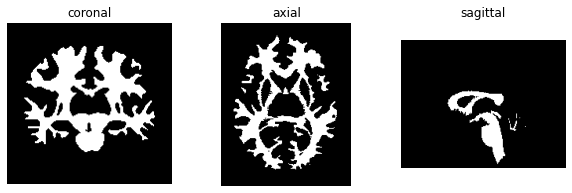

In [ ]:
# load ground truth segmentation
sitk_gt = sitk.ReadImage('template/wm.nii.gz', sitk.sitkFloat32)
Display3D(sitk_gt)